(10, 10, 10)
(9, 60)


100%|██████████| 500000/500000 [26:13<00:00, 317.80it/s]


(5001, 1, 9)


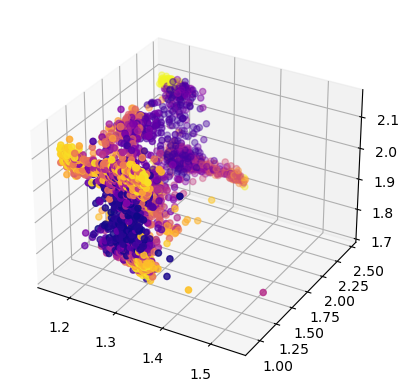

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import RegularGridInterpolator
import numpy.linalg as la
from tqdm import tqdm

datadict_PES = scipy.io.loadmat('../H_reaction9/R09PES3D.mat')
max_PES = np.max(datadict_PES['V'])
box = np.zeros((3, 2))
for idx, item in enumerate(['X', 'Y', 'Z']):
    box[idx, 0] = np.min(datadict_PES[item])
    box[idx, 1] = np.max(datadict_PES[item])

threshold = np.sqrt(1e-1)

# Create a 3D grid
X, Y, Z = np.meshgrid(datadict_PES['X'], datadict_PES['Y'], datadict_PES['Z'], indexing='ij')
XYZ_ = np.concatenate((np.reshape(X, (-1, 1)), np.reshape(Y, (-1, 1)), np.reshape(Z, (-1, 1))), axis=1)
V = datadict_PES['V']
V = V.reshape(-1)
print(datadict_PES['V'].shape)
# Create a RegularGridInterpolator
interpolator = RegularGridInterpolator((datadict_PES['X'][:, 0], datadict_PES['Y'][:, 0], datadict_PES['Z'][:, 0]), datadict_PES['V'])

def is_inside_box(x, box):
    if len(x) != len(box):
        print(x.shape, box.shape)
        raise ValueError("Vector dimensions must match the number of box dimensions")

    for i in range(len(x)):
        if not (box[i][0] < x[i] < box[i][1]):
            return False
    return True


def harmonic_potential_outside_box(x, box):
    if len(x) != len(box):
        raise ValueError("Vector dimensions must match the number of box dimensions")
    harmonic_potential = 0
    coef = 10000
    harmonic_potential = np.sum(coef * (np.maximum(box[:, 0] - x, 0)) ** 2 + coef * (np.maximum(x - box[:, 1], 0)) ** 2)

    return harmonic_potential


def potential(x):
    z = cart2zmat(x)

    if is_inside_box(z, box):
        return interpolator(z.reshape(1, -1))
    else:
        # print(x.reshape(1,-1).shape, XYZ_.shape)
        distances = np.linalg.norm(z.reshape(1, -1) - XYZ_, axis=1)
        minidx = np.argmin(distances)
        return V[minidx] + harmonic_potential_outside_box(z.reshape(-1), box)


def torsion(xyzs, i, j, k):
    # compute the torsion angle for atoms i,j,k
    ibeg = (i - 1) * 3
    iend = i * 3
    jbeg = (j - 1) * 3
    jend = j * 3
    kbeg = (k - 1) * 3
    kend = k * 3

    rij = xyzs[ibeg:iend] - xyzs[jbeg:jend]
    rkj = xyzs[kbeg:kend] - xyzs[jbeg:jend]
    cost = np.sum(rij * rkj)
    sint = la.norm(np.cross(rij, rkj))
    angle = np.arctan2(sint, cost)
    return angle


def cart2zmat(X):
    X = X.T
    nrows, ncols = X.shape
    na = nrows // 3
    Z = []

    for j in range(ncols):
        rlist = []  # list of bond lengths
        alist = []  # list of bond angles (radian)
        dlist = []  # list of dihedral angles (radian)
        # calculate the distance matrix between atoms
        distmat = np.zeros((na, na))
        for jb in range(na):
            jbeg = jb * 3
            jend = (jb + 1) * 3
            xyzb = X[jbeg:jend, j]
            for ia in range(jb + 1, na):
                ibeg = ia * 3
                iend = (ia + 1) * 3
                xyza = X[ibeg:iend, j]
                distmat[ia, jb] = la.norm(xyza - xyzb)
        distmat = distmat + np.transpose(distmat)

        if na > 1:
            rlist.append(distmat[0, 1])

        if na > 2:
            rlist.append(distmat[0, 2])
            alist.append(torsion(X[:, j], 3, 1, 2))

        Z.append(rlist + alist + dlist)

    Z = np.array(Z)
    return Z.T

def PCA(data): # datasize: N * dim
    # Step 4.1: Compute the mean of the data
    
    data_z = data # bs*3
    
    mean_vector = np.mean(data_z, axis=0, keepdims=True)
    std_vector = np.std(data_z, axis=0, keepdims=True)
    
    # Step 4.2: Center the data by subtracting the mean
    centered_data = (data_z - mean_vector)
    # print('PCA', data.shape, cart2zmat(data).shape)
    # Step 4.3: Compute the covariance matrix of the centered data
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Step 4.4: Perform eigendecomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4.5: Sort the eigenvectors based on eigenvalues (descending order)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 4.6: Choose the number of components (optional)
    k = 3  # Set the desired number of components

    # Step 4.7: Retain the top k components
    selected_eigenvectors = eigenvectors[:, 0:k]

    # Step 4.8: Transform your data to the new lower-dimensional space
    transformed_data = np.dot(centered_data, selected_eigenvectors)
    # print('selected_eigenvector:', data.shape, data_z.shape, eigenvectors.shape, selected_eigenvectors.shape)
    # print(np.dot(centered_data, selected_eigenvectors)-np.matmul(centered_data, selected_eigenvectors))
    return mean_vector, std_vector, selected_eigenvectors, eigenvalues


def gradV(x): # x shape 1*9
    eps = 1e-3
    f = potential(x)
    grad = np.zeros_like(x)

    for i in range(x.shape[1]):
        x_plus_h = x.copy()
        x_plus_h[0,i] += eps
        f_plus_h = potential(x_plus_h)
        grad[0, i] = (f_plus_h - f) / eps

    return grad

def Gaussian(x, qx, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma):
    # x the point we what calculate the value
    # gaussian deposit
    # method the way that we want deposit gaussian
    V = None
    if method == 'second_bond':
        # print(x.shape, qx.shape)
        q_z = cart2zmat(x).T
        qs_z = qsz # cart2zmat(qx).T
        # print(q_z.shape, qs_z.shape)
        V = height * np.sum(np.exp(-(q_z[0,1] - qs_z[:,1])**2/2/sigma**2))
    elif method == 'first_three_eigen':
        # print('qx shape', qx.shape, save_eigenvector_s.shape)
        x_z = cart2zmat(x).T
        # print('eigen: ', x_z.shape, qsz.shape, save_eigenvector_s.shape) # 1*3, gn*3, gn*3*k
        dist = np.sum(np.expand_dims((x_z - qsz), axis=2)*save_eigenvector_s, axis=1)**2
        # local_bool = (np.sum((x_z - qsz)**2, axis=-1) < threshold**2)
        # print(dist.shape) # gn*k
        # print(choose_eigenvalue.shape, dist.shape)
        exps = np.exp(-np.sum(dist*choose_eigenvalue, axis=1)/2/sigma**2)
        # print(dist, np.exp(-np.sum(dist, axis=1)/2/sigma**2), exps, local_bool, np.sum((x - qx)**2, axis=-1))
        # exps = np.exp(np.sum(dist, axis=1)/2/sigma**2)
        # print(local_bool)
        # print(local_bool.shape, exps.shape, np.sum(local_bool))
        # print(height, sigma, exps)
        V = height * np.sum(exps)
        # print('hehe')
        # print(x.shape)
        # print(qx.shape)  #(1, 9)
        # print(save_eigenvector_s.shape) #(1, 9, 3)
    return V


def gradGaussians(x, qs, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma):
    eps = 1e-2
    f = Gaussian(x, qs, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma)
    grad = np.zeros_like(x)

    for i in range(x.shape[1]):

        x_plus_h = x.copy()
        x_plus_h[0, i] += eps
        f_plus_h = Gaussian(x_plus_h, qs, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma)
        grad[0, i] = (f_plus_h - f) / eps
        # print(f_plus_h, f)
    return grad


def MD(q0, T, Tdeposite, height, sigma, dt=1e-3, beta=1.0, coarse=1):
    Nsteps = round(T / dt)
    NstepsDeposite = round(Tdeposite / dt)
    NstepsSave = round(T / (dt * coarse))
    trajectories = np.zeros((NstepsSave + 1, 1, 9))
    trajectories_PCA = np.zeros((NstepsDeposite, 1, 3))

    q = q0
    qs = None
    qsz = None
    qstd = None
    save_eigenvector_s = None
    save_eigenvalue_s = None
    choose_eigenvalue = None
    method = 'first_three_eigen'
    variance = 0.8
    for i in tqdm(range(Nsteps)):
        trajectories[i // coarse, :] = q
        q = next_step(q, qs, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma, dt, beta) # 1*9
        trajectories_PCA[i % NstepsDeposite, :] = cart2zmat(q).T
        if i % coarse == 0:
                trajectories[i // coarse, :] = q

        if (i + 1) % NstepsDeposite == 0:
            if qs is None:

                ### conducting PCA ###
                data = trajectories_PCA  # (N_steps, 1, 2)
                # print(i, trajectories_PCA)
                data = np.squeeze(data, axis=1)  # (100, 2)
                mean_vector, std_vector, selected_eigenvectors, eigenvalues = PCA(data)
                # print(selected_eigenvectors.shape, eigenvalues.shape)
                qs = mean_vector#q
                # print(mean_vector.shape)
                qsz = mean_vector#cart2zmat(qs).T
                qstd = std_vector
                
                ### reset the PCA dataset
                trajectories_PCA = np.zeros((NstepsDeposite, 1, 3))
                
                save_eigenvector_s = np.expand_dims(selected_eigenvectors, axis=0)
                save_eigenvalue_s = np.expand_dims(eigenvalues, axis=0)
                
                choose_eigenvalue_tmp = np.zeros((1,3))
                cumsum = np.cumsum(save_eigenvalue_s, axis=1)
                var_ratio = cumsum/np.sum(save_eigenvalue_s)
                idx = np.argmax(var_ratio>variance)
                # print(save_eigenvalue_s, cumsum/np.sum(save_eigenvalue_s), np.argmax(var_ratio>variance))
                for s in range(idx+1):
                    choose_eigenvalue_tmp[0,s]=1
                choose_eigenvalue = choose_eigenvalue_tmp
                # print(choose_eigenvalue)
                # for k in range(3):
                #     cumsum = np.cumsum(save_eigenvalue_s, axis=1)
                    
                # print(save_eigenvector_s.shape, save_eigenvalue_s.shape)
            else:
                ### conducting PCA ###
                data = trajectories_PCA  # (N_steps, 1, 2)
                # print(i, trajectories_PCA)
                data = np.squeeze(data, axis=1)  # (100, 2)
                mean_vector, std_vector, selected_eigenvectors, eigenvalues = PCA(data)

                q_deposit = q
                q_deposit = mean_vector
                # print(mean_vector.shape, 'mean vector')
                qs = np.concatenate([qs, q_deposit], axis=0)
                # qsz = np.concatenate([qsz, cart2zmat(q_deposit).T], axis=0)
                qsz = np.concatenate([qsz, q_deposit], axis=0)
                qstd = np.concatenate([qstd, std_vector], axis=0)
                
                save_eigenvector_s = np.concatenate([save_eigenvector_s, np.expand_dims(selected_eigenvectors, axis=0)], axis=0)
                save_eigenvalue_s = np.concatenate([save_eigenvalue_s, np.expand_dims(eigenvalues, axis=0)], axis=0)
                
                eigenvalues = np.expand_dims(eigenvalues, axis=0)
                choose_eigenvalue_tmp = np.zeros((1,3))
                cumsum = np.cumsum(eigenvalues, axis=1)
                var_ratio = cumsum/np.sum(eigenvalues)
                idx = np.argmax(var_ratio>variance)
                # print(eigenvalues, var_ratio, np.argmax(var_ratio>variance))
                for s in range(idx+1):
                    choose_eigenvalue_tmp[0,s]=1
                choose_eigenvalue = np.concatenate([choose_eigenvalue, choose_eigenvalue_tmp], axis=0)
                # print(choose_eigenvalue)
                
                # print(save_eigenvector_s.shape, save_eigenvalue_s.shape)
                # print(i, qs.shape, qsz.shape)

                # print(i, trajectories_PCA.shape, trajectories_PCA)

                trajectories_PCA = np.zeros((NstepsDeposite, 1, 3))
    trajectories[NstepsSave, :] = q
    return trajectories, qs, save_eigenvector_s, save_eigenvalue_s


def next_step(qnow, qs, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma, dt=1e-3, beta=1.0):

    if qs is None:
        qnext = qnow + (- gradV(qnow)) * dt + np.sqrt(2 * dt / beta) * np.random.randn(*qnow.shape)
        # print('grad size', gradV(qnow).shape)
    else:
        # print(gradGaussians(qnow, qs, qstd, qsz, method, save_eigenvector_s, height, sigma))
        # print(qsz)
        qnext = qnow + (- (gradV(qnow) + gradGaussians(qnow, qs, qstd, qsz, method, choose_eigenvalue, save_eigenvector_s, height, sigma))) * dt + np.sqrt(2 * dt / beta) * np.random.randn(*qnow.shape)

    return qnext


if __name__ == '__main__':

    # fig = plt.figure(figsize=(10, 6))
    # ax1 = fig.add_subplot(1, 2, 1)
    # contourf_ = ax1.contourf(X, Y, W, levels=29)

    T = 10
    cmap = plt.get_cmap('plasma')
    ircdata = scipy.io.loadmat('../H_reaction9/irc09.mat')['irc09'][0][0][3]
    # x0 = ircdata[:, -2:-1].T  # 1*9
    x0 = ircdata[:, 5:6].T
    print(ircdata.shape)
    exit()
    coarse = 100
    for i in range(1):
        trajectories, qs, save_eigenvector_s, save_eigenvalue_s = MD(x0, T = T, Tdeposite=1e-2, height=1, sigma=0.3, dt=2e-5, beta=1, coarse=coarse)

    print(trajectories.shape)

    z_trajectory = (cart2zmat(trajectories[:,0])).T

    indices = np.arange(z_trajectory.shape[0])
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_trajectory[:, 0], z_trajectory[:, 1], z_trajectory[:, 2], c=indices, cmap=cmap)
    plt.show()
    np.savez('T10_deposit5e-3_dt2e-5-PCAs-InternalCoordinates_height1_T10_debug-nonlocal', z = z_trajectory, x = trajectories, qs=qs, eignvectors=save_eigenvector_s, eigenvalues=save_eigenvalue_s)

    #     # print(trajectory.shape)
    #     indices = np.arange(trajectory.shape[0])
    #     ax1.scatter(trajectory[:, 0, 0], trajectory[:, 0, 1], c=indices, cmap=cmap)
    #
    # print(qs.shape)
    # Gs = GaussiansPCA(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1), qs, eigenvectors, height=0.1,
    #                   sigma=0.1)
    # ax2 = fig.add_subplot(1, 2, 2)
    # ax2.contourf(X, Y, Gs.reshape(100, 100), levels=29)
    # indices = np.arange(qs.shape[0])
    # cmap = plt.get_cmap('plasma')
    # # ax2.scatter(qs[::-1, 0], qs[::-1, 1], c=indices, cmap=cmap)
    # # ax2.quiver(qs[:, 0], qs[:, 1], eigenvectors[0,:], eigenvectors[1,:])
    # # fig.colorbar(contourf_)
    # plt.title('Local PCA dynamics')
    # plt.show()


# if __name__ == '__main__':

#     cmap = plt.get_cmap('plasma')
#     ircdata = scipy.io.loadmat('irc09.mat')['irc09'][0][0][3]

#     x0 = (ircdata[:,5]) # 1*9
#     T = 2
#     for i in range(1):
#         trajectory = MD(x0, T, dt=1e-3, beta=1.0) #(steps, bs, dim)
#         print(trajectory.shape)
#     indices = np.arange(trajectory.shape[0])
#     ax1.scatter(trajectory[:,0, 0], trajectory[:,0, 1], c=indices, cmap=cmap)
# #     np.savez(foldername + '/Meta' + str(args.trial), trajectory = trajectory, centers = qs)



In [5]:
import numpy as np

datadict = np.load('T10_deposit5e-3_dt2e-5-PCA3.npz')
qs = datadict['qs']
save_eigenvector_s = datadict['eignvectors']
z_trajectory = datadict['z']

print(qs.shape)
print(save_eigenvector_s.shape)

(1000, 9)
(1000, 9, 2)


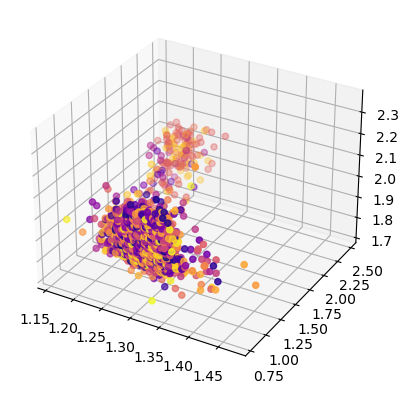

In [9]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap('plasma')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
indices = np.arange(z_trajectory.shape[0])
ax.scatter(z_trajectory[:, 0], z_trajectory[:, 1], z_trajectory[:, 2], c=indices, cmap=cmap)
plt.show()

In [16]:
import numpy.linalg as la

def torsion(xyzs, i, j, k):
    # compute the torsion angle for atoms i,j,k
    ibeg = (i - 1) * 3
    iend = i * 3
    jbeg = (j - 1) * 3
    jend = j * 3
    kbeg = (k - 1) * 3
    kend = k * 3

    rij = xyzs[ibeg:iend] - xyzs[jbeg:jend]
    rkj = xyzs[kbeg:kend] - xyzs[jbeg:jend]
    cost = np.sum(rij * rkj)
    sint = la.norm(np.cross(rij, rkj))
    angle = np.arctan2(sint, cost)
    return angle

def cart2zmat(X):
    X = X.T
    nrows, ncols = X.shape
    na = nrows // 3
    Z = []

    for j in range(ncols):
        rlist = []  # list of bond lengths
        alist = []  # list of bond angles (radian)
        dlist = []  # list of dihedral angles (radian)
        # calculate the distance matrix between atoms
        distmat = np.zeros((na, na))
        for jb in range(na):
            jbeg = jb * 3
            jend = (jb + 1) * 3
            xyzb = X[jbeg:jend, j]
            for ia in range(jb + 1, na):
                ibeg = ia * 3
                iend = (ia + 1) * 3
                xyza = X[ibeg:iend, j]
                distmat[ia, jb] = la.norm(xyza - xyzb)
        distmat = distmat + np.transpose(distmat)

        if na > 1:
            rlist.append(distmat[0, 1])

        if na > 2:
            rlist.append(distmat[0, 2])
            alist.append(torsion(X[:, j], 3, 1, 2))

        Z.append(rlist + alist + dlist)

    Z = np.array(Z)
    return Z.T

qsz = cart2zmat(qs).T
print(qsz.shape)

(1000, 3)


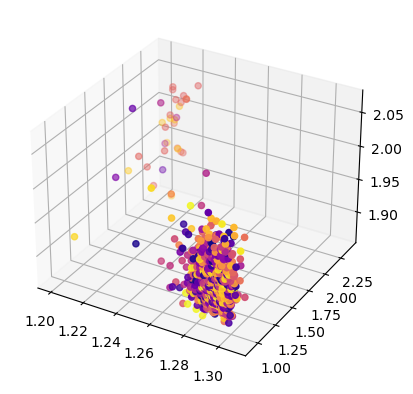

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
indices = np.arange(qsz.shape[0])
ax.scatter(qsz[:, 0], qsz[:, 1], qsz[:, 2], c=indices, cmap=cmap)
plt.show()

(1000, 3)


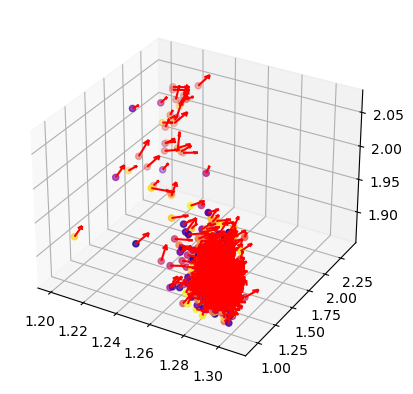

In [23]:
pca1z = cart2zmat(save_eigenvector_s[:,:,0]).T
print(pca1z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Create arrows at scatter points
indices = np.arange(qsz.shape[0])
ax.scatter(qsz[:, 0], qsz[:, 1], qsz[:, 2], c=indices, cmap=cmap)
ax.quiver(qsz[:, 0], qsz[:, 1], qsz[:, 2], pca1z[:, 0], pca1z[:, 1], pca1z[:, 2], length=0.01, color='r', label='Arrows')
plt.show()

(1000, 3)


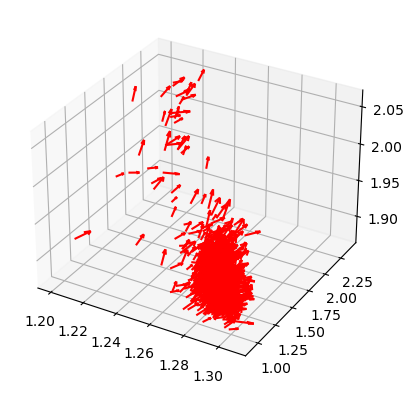

In [22]:
pca2z = cart2zmat(save_eigenvector_s[:,:,1]).T
print(pca1z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Create arrows at scatter points
indices = np.arange(qsz.shape[0])
ax.scatter(qsz[:, 0], qsz[:, 1], qsz[:, 2], c=indices, cmap=cmap)
ax.quiver(qsz[:, 0], qsz[:, 1], qsz[:, 2], pca2z[:, 0], pca2z[:, 1], pca2z[:, 2], length=0.01, color='r', label='Arrows')
plt.show()

(1000, 3)


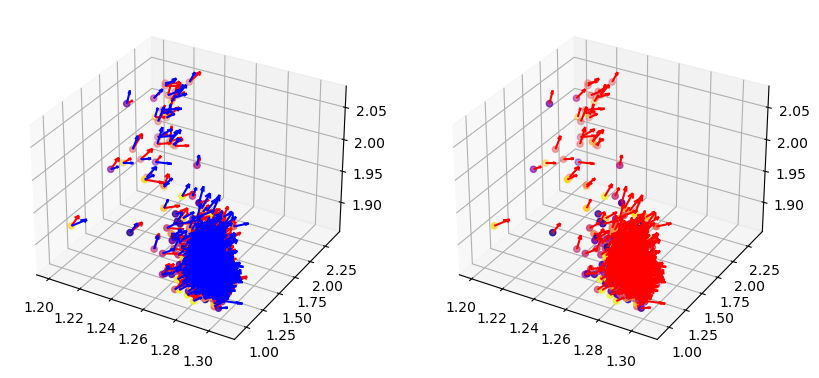

In [27]:
pca1z = cart2zmat(save_eigenvector_s[:,:,0]).T
pca2z = cart2zmat(save_eigenvector_s[:,:,1]).T
print(pca1z.shape)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
# Create arrows at scatter points
indices = np.arange(qsz.shape[0])
ax.scatter(qsz[:, 0], qsz[:, 1], qsz[:, 2], c=indices, cmap=cmap)
ax.quiver(qsz[:, 0], qsz[:, 1], qsz[:, 2], pca1z[:, 0], pca1z[:, 1], pca1z[:, 2], length=0.01, color='r', label='Arrows')
ax.quiver(qsz[:, 0], qsz[:, 1], qsz[:, 2], pca2z[:, 0], pca2z[:, 1], pca2z[:, 2], length=0.01, color='b', label='Arrows')

ax = fig.add_subplot(122, projection='3d')
indices = np.arange(qsz.shape[0])
ax.scatter(qsz[:, 0], qsz[:, 1], qsz[:, 2], c=indices, cmap=cmap)
ax.quiver(qsz[:, 0], qsz[:, 1], qsz[:, 2], pca2z[:, 0], pca2z[:, 1], pca2z[:, 2], length=0.01, color='r', label='Arrows')

plt.show()